In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import pairwise_distances


In [197]:
# loading dataset and printing first 5 rows
url = r"C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 4\marathon_results_.csv"
data = pd.read_csv(url)
data.head()

testa = data.copy()

In [23]:
# concise summary od dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-null int64
G

In [24]:
# checking for missing values
data.isnull().sum()

Unnamed: 0           0
Bib                  0
Name                 0
Age                  0
M/F                  0
City                 0
State             3595
Country              0
Citizen          25156
Unnamed: 9       26319
5K                   0
10K                  0
15K                  0
20K                  0
Half                 0
25K                  0
30K                  0
35K                  0
40K                  0
Pace                 0
Proj Time            0
Official Time        0
Overall              0
Gender               0
Division             0
dtype: int64

In [25]:
# checking for unique catrgories in categorical variables
cat = ['M/F','Country','State','Citizen', 'Division', 'Gender', 'City']
data[cat].nunique()

M/F             2
Country        91
State          68
Citizen        85
Division     5846
Gender      14438
City         5926
dtype: int64

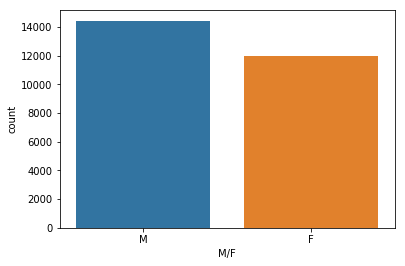

In [26]:
# gender distribution
_ = sns.countplot(data['M/F'])
plt.show()

# Cleaning & Manipulation
First, I'll clean dataset from unwanted special character and convert all datetime represented columns into minute representation to facilitate feature normalization

In [27]:
# replace  '-' with 0
for column in (set(data.columns.tolist()) - set(['Name'])): 
    data[column] = data[column].replace('-',0)
    
# this function converts H:m:s representation into minutes
def str_to_number(time_str):
    if not isinstance(time_str, str):
        return 0
    hour, minute, sec = [int(x) for x in time_str.split(':')]
    return hour*60 + minute + sec/60

# time represented columns
time_cols = ['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', 'Half', 'Pace', 'Official Time']
for time in time_cols:
    data[time] = data[time].map(str_to_number)

# Feature Engineering
Runners in Boston Marathon are represented in 14 age categories. I'll define a fucntion to categorize ages of participants. 

In [28]:
# M/F to binary representation
features = data.copy()
features ['M/F'] = np.where(features['M/F'] == 'M', 1, 0)

In [29]:
# categories
ages = {'14-19':(14,19),
        '20-24':(20,24),
        '25-29':(25,29),
        '30-34':(30,34),
        '35-39':(35,39),
        '40-44':(40,44),
        '45-49':(45,49),
        '50-54':(50,54),
        '55-59':(55,59),
        '60-64':(60,64),
        '65-69':(65,69),
        '70-74':(70,74),
        '75-79':(75,79),
        '80+':(80,90)}

# this function is defined to categorize age distribution
def categorize(age):
    for key in ages:
        if (ages[key][0] <= age <= ages[key][1]):
            return key

# categorize age
features['Age'] = features['Age'].apply(lambda age: categorize(age))

According to http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm, bib numbers represent which category a participant belongs to. Bib numbers are color coded. There are 4 categories: Red, White, Blue, Yellow. 

In [30]:
bib_cats = {'elite':(0,100),
             'red':(101,8999),
             'white':(9000,17999),
             'blue':(18000,26999),
             'yellow':(27000, 50000)}

# Define a function to convert bib number to category
def convert_bib(x):    
    try:
        for key in bib_cats:
            if bib_cats[key][0] <= float(x) <= bib_cats[key][1]: return key             
    except ValueError:   
        if 'W' in str(x): return 'elite'
        elif 'F' in str(x): return 'elite'    
    else: 
        print(float(x))
        return np.nan
# create waves column
features['waves'] = data['Bib'].apply(lambda x: convert_bib(x))


In [31]:
drop = ['Bib', 'Name', 'City', 'State', 'Country', 'Unnamed: 0', 'Unnamed: 9', 'Proj Time', 'Citizen']
features = features.drop(columns = drop, axis = 1)
features.head(2)

,Age,M/F,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Official Time,Overall,Gender,Division,waves
0,20-24,1,15.416667,30.466667,45.733333,61.25,64.583333,76.983333,93.016667,108.316667,122.883333,4.950000,129.616667,1,1,1,elite
1,30-34,1,15.400000,30.450000,45.733333,61.25,64.583333,76.983333,93.016667,108.316667,123.233333,4.966667,129.966667,2,2,2,elite


In [32]:
features.isnull().sum()

Age              0
M/F              0
5K               0
10K              0
15K              0
20K              0
Half             0
25K              0
30K              0
35K              0
40K              0
Pace             0
Official Time    0
Overall          0
Gender           0
Division         0
waves            0
dtype: int64

# Preprocessing

In [33]:
# Make sure the number of rows divides evenly into four samples.
rows = features.shape[0] - features.shape[0] % 4
features = features.iloc[:rows, :]

X = pd.get_dummies(features)

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
y_pred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.


# KMeans Clustering

In [159]:
cluster_scores = pd.DataFrame(columns=['clusters','mean score','std'])
clust_range = range(2,10)
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into y_pred.
    y_pred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    y_pred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 12.
    for nclust in clust_range:
        model = KMeans(n_clusters=nclust, random_state=42).fit(data[0])
        labels = model.labels_
        y_pred['clust' + str(nclust) + '_sample' + str(counter)] = model
        y_pred['sil_score_' + 'clust'+ str(nclust) + '_sample' + str(counter)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')

        
for nclust in clust_range:
    sil_scores = []

    for i in range(4):

        current_group = (f'clust{nclust}_sample{i}')
        

        sil_score = y_pred['sil_score_' + str(current_group)].mean()
        sil_scores.append(sil_score)

    group_mean = np.mean(sil_scores)
    group_std = np.std(sil_scores)
    cluster_scores = cluster_scores.append({'clusters':int(nclust), 'mean score': group_mean, 
                                            'std': group_std}, ignore_index=True)
    
print(cluster_scores)
   

   clusters  mean score       std
0       2.0    0.426450  0.000695
1       3.0    0.473757  0.002232
2       4.0    0.493102  0.002986
3       5.0    0.445198  0.002910
4       6.0    0.429857  0.002838
5       7.0    0.516354  0.001545
6       8.0    0.519203  0.000917
7       9.0    0.526116  0.007727


It appears that the two-cluster solution yields the most consistent results in terms of cluster center and cluster shape.

In [170]:
# Generate cluster predictions and store them for clusters 2 to 12.
pred_clust = pd.DataFrame()
for i in [X1, X2, X3, X4]:
    bandwidth = estimate_bandwidth(i, quantile=0.6, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(i)    
    labels = ms.labels_ # Extract cluster assignments for each data point.       
    n_clusters_ = len(np.unique(labels)) # Count our clusters.
    print("Number of estimated clusters: {}".format(n_clusters_)) 
    print(metrics.silhouette_score(i, labels, metric='euclidean'))
    

Number of estimated clusters: 2
0.7072158395005685
Number of estimated clusters: 3
0.6293723760925894
Number of estimated clusters: 2
0.7188709665431621
Number of estimated clusters: 3
0.5952690902956774
